<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://developer.nvidia.com/sites/default/files/akamai/embedded/images/EDU/DLI%20Asset%20-%20Logo.jpg" width="400" height="186" /></a></center>

# Speed Up DataFrame Operations w/ RAPIDS cuDF
A **DataFrame** is a 2-dimensional data structure used to represent data in a tabular format, like a spreadsheet or SQL table. Originally offered through the Python Data Analysis (pandas) library, DataFrames have become very popular for its familiar representation as well as a robust set of features that are intuitive and expressive. 

Raw Data needs to be maniupulated before it can be used for further analysis. These preprocessing steps can include filtering, merging, grouping, and aggregating. 

Below is a typical data processing pipeline: 
![pipeline](https://github.com/NVDLI/notebooks/blob/kl/cudf_speed_up/images/flow.png?raw=true)

Reportedly, data preparation accounts for ~80% of the work of analysts. This could be the rapidly increase in the size of data as well as the iterative nature of analytics. 

Before data can be used for Business Intelligence, Dashboard Visualization, or Machine Learning, there is significant time spent on developing a robust data preprocessing pipeline. From initially loading the data, a typical pipeline might include data cleaning, data wrangling, and feature engineering. 

Recognizing this potential bottleneck, NVIDIA created cuDF that leverages its GPU hardware and software to perform data manipulation tasks with parallel computing. cuDF is a Python GPU DataFrame library (built on the Apache Arrow columnar memory format) for loading, joining, aggregating, filtering, and otherwise manipulating tabular data using a DataFrame style API. 

This notebook is intended to provide analysts with an alternative to the popular pandas library that leverages GPU for parallel computing. 

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

Thu Aug 12 23:19:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   6390MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. BlazingSQL
  1. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.


In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/u

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Traditionally, these tasks are frequently done using the popular pandas library, which only runs on a single CPU. NVIDIA's cuDF library was built with the users in mind - by offering nearly identical syntax to its CPU counterpart, developers only have to make few changes to their existing code to take advantage of its capabilities. 

### Importing Dependencies

In [ ]:
import numpy as np # for generating sample data

# import cudf, io, requests
from io import StringIO
import io, requests, time

# import pandas as df
import cudf as df
import time # for clocking process times
import matplotlib.pyplot as plt # for visualizing results

ModuleNotFoundError: ignored

We start our analysis by loading the data

In [ ]:
def load_data():
  start=time.time()
  # url="https://github.com/plotly/datasets/raw/master/tips.csv"
  # content=requests.get(url).content.decode('utf-8')
  # tips_df = cudf.read_csv(StringIO(content))
  # dataframe=df.read_csv(StringIO(content))
  data=np.random.rand(1000000, 100)
  dataframe=df.DataFrame(data)
  process_time=time.time()-start
  print(f'The loading process took {process_time} seconds')
  return dataframe, process_time
dataframe, process_time=load_data()

The loading process took 0.7424914836883545 seconds


Next, we can perform univariate statistics with the ```df.describe()``` method: 

In [ ]:
def summarize(dataframe):
  start=time.time()
  dataframe.describe()
  process_time=time.time()-start
  print(f'The summarizing process took {process_time} seconds')
  return process_time
summarize(dataframe)

The summarizing process took 8.709380865097046 seconds


8.709380865097046

We will want to perform bi-variate statistics such as correlation between two variables using the df.corr() method: 

In [ ]:
def correlation(dataframe): 
  start=time.time()
  dataframe.corr()
  process_time=time.time()-start
  print(f'The correlation process took {process_time} seconds')
  return process_time
correlation(dataframe)

The correlation process took 19.9680278301239 seconds


19.9680278301239

We can simplify our analysis by binning and grouping continuous variables with the pd.cut() and cudf.cut() methods, followed by df.groupby(): 

In [ ]:
# dataframe.head()
# len(dataframe)

In [ ]:
def groupby_summarize(dataframe):
  start=time.time()
  dataframe['group']=df.cut(dataframe.iloc[:, 0], 10)
  dataframe.groupby('group').describe()
  process_time=time.time()-start
  print(f'The grouping process took {process_time} seconds')
  return process_time
groupby_summarize(dataframe)

The grouping process took 6.057166814804077 seconds


6.057166814804077

Sometimes we need to merge mulitple data sets together with the df.merge() method: 

In [ ]:
def merge(dataframe): 
  start=time.time()
  dataframe.merge(dataframe, left_index=True, right_index=True)
  process_time=time.time()-start
  print(f'The merging process took {process_time} seconds')
  return process_time
merge(dataframe)
# dataframe.merge(dataframe, left_index=True, right_index=True)#, left_on=0, right_on=0)#, left_index=True, right_index=True)

The merging process took 1.7534675598144531 seconds


1.7534675598144531

In [ ]:
def pipeline():
  performance={}
  dataframe, performance['load data']=load_data()
  performance['summarize']=summarize(dataframe)
  performance['correlation']=correlation(dataframe)
  performance['groupby_summarize']=groupby_summarize(dataframe)
  performance['merge']=merge(dataframe)
  try: 
    df.DataFrame([performance], index=['gpu']).to_pandas().plot(kind='bar', stacked=True)
  except: 
    df.DataFrame([performance], index=['cpu']).plot(kind='bar', stacked=True)
  return None

The loading process took 0.7361698150634766 seconds
The summarizing process took 8.694564580917358 seconds
The correlation process took 20.019218921661377 seconds
The grouping process took 5.726263046264648 seconds
The merging process took 1.7538578510284424 seconds


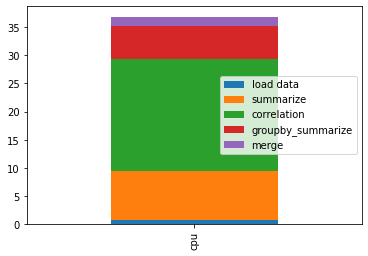

In [ ]:
pipeline()

The loading process took 1.0965628623962402 seconds
The summarizing process took 1.7420973777770996 seconds
The correlation process took 0.18835878372192383 seconds
The grouping process took 2.6601593494415283 seconds
The merging process took 0.10985445976257324 seconds


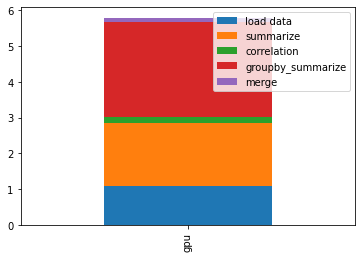

In [ ]:
import cudf as df
pipeline()

### Where to go from here
Help us prioritize your feature request by contributing to our GitHub repository. 

* sectional headers
* end blurb to direct to DLI (might also in the beg.)
* expand data set
DP
* DLI logo (high rez imagefrom KY)
* 

